# Test notebook for Acceptance Test Campaign related to LSST Science Pipelines Release 19.0.0

This test will be executed on the LSST Science Platform Notebook Aspect, initialized with Science Pipelines release `r19-0-0`.

### Testing - load calexp and calexpBackground and display them:

Checking a few random images to see whether the background frame exists, and what it looks like.

### Test case LVV-T43: Verify implementation of Background Model Calculation
Verify that Processed Visit Images produced by the DRP and AP pipelines have had a model of the background subtracted, and that this model is persisted in a way that permits the background subtracted from any CCD to be retrieved along with the image for that CCD.

In [1]:
# Confirm that the version of the Science Pipelines is v19_0_0:
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-jcarlin-r19-0-0
lsst_distrib          19.0.0+2   	current v19_0_0 setup


In [2]:
import lsst.daf.persistence as dafPersist

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import random

from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)

In [4]:
# Set some plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
zscale = ZScaleInterval()

plt.rcParams.update({'figure.figsize' : (12, 8)})
plt.rcParams.update({'font.size' : 12})
plt.rcParams.update({'axes.linewidth' : 3})
plt.rcParams.update({'axes.labelweight' : 3})
plt.rcParams.update({'axes.titleweight' : 3})
plt.rcParams.update({'ytick.major.width' : 3})
plt.rcParams.update({'ytick.minor.width' : 2})
plt.rcParams.update({'ytick.major.size' : 8})
plt.rcParams.update({'ytick.minor.size' : 5})
plt.rcParams.update({'xtick.major.size' : 8})
plt.rcParams.update({'xtick.minor.size' : 5})
plt.rcParams.update({'xtick.major.width' : 3})
plt.rcParams.update({'xtick.minor.width' : 2})
plt.rcParams.update({'xtick.direction' : 'in'})
plt.rcParams.update({'ytick.direction' : 'in'})

We will use HSC-RC2, as processed using `w_2019_46`, which is the pipelines version that was used to create `v19_0_0`.

In [5]:
# The output repo is tagged with the Jira ticket number "DM-22223":
rc2_repo = '/datasets/hsc/repo/rerun/RC/w_2019_46/DM-22223'

In [6]:
# Initialize the butler repo:
butler = dafPersist.Butler(rc2_repo)

# Make a glob of the files in the repo, so we can parse this to get tract/patch IDs:
infiles = glob.glob(rc2_repo+'/deepCoadd/HSC-*/*/*/warp-*.fits')
print(len(infiles))

16575


#### Make arrays of the tract, patch, and visit numbers by parsing the filenames

In [7]:
tract_array = []
patch_array = []
visit_array = []

# Each line of "infiles" looks like this (infile[0]):
# '/datasets/hsc/repo/rerun/RC/w_2019_46/DM-22223/deepCoadd/HSC-R/9615/8,8/warp-HSC-R-9615-8,8-23902.fits'

# Split on the '/', then parse the resulting array. Here's the result of infiles[0].split('/'):

#['',
# 'datasets',
# 'hsc',
# 'repo',
# 'rerun',
# 'RC',
# 'w_2019_46',
# 'DM-22223',
# 'deepCoadd',
# 'HSC-R',
# '9615',
# '8,8',
# 'warp-HSC-R-9615-8,8-23902.fits']

# So the tract number is third from the end, and patch is second from the end.

for ii in range(0, len(infiles)):
    parts = infiles[ii].split('/')
    tract_array.append(int(parts[-3]))
    patch_array.append(parts[-2])
    # Split the file name to extract the visit number:
    file_str = parts[-1]
    file_str2 = file_str.split('.fits')
    file_str3 = file_str2[0].split('-')
    visit_array.append(file_str3[-1])

print('Found %i patches'%(len(patch_array)))
        
# Assemble in pandas data frame    
data = {'tract': tract_array,
        'patch': patch_array,
        'visit': visit_array}
df_tract_patch_visit = pd.DataFrame(data=data)

Found 16575 patches


In [8]:
# df_tract_patch_visit

In [9]:
# Check the tract names that are available:
print('The repo contains of the following visits: ',df_tract_patch_visit.tract.unique())

The repo contains of the following visits:  [9615 9813 9697]


In [10]:
# Select some visit/tract/patch combinations from these at random:
numvisits = 100 # Number of random datarefs to select
patch_sel = df_tract_patch_visit.sample(numvisits)

In [11]:
#patch_sel

In [12]:
# CCDs number from 0-111. Randomly select a CCD for each of the visits:
ccdnums = np.random.randint(112, size=numvisits)

# CCD 9 is bad, so generate a new array until we have no "9" values in it:
exclude_ccds = [9]
while ccdnums.any() in exclude_ccds:
    ccdnums = np.random.randint(112, size=numvisits)

##############################################################
# Select all CCDs for each of the visits:
ccdnums_all = np.arange(112)

# CCD 9 is bad, so remove CCD 9 from the list:
ccdnums_all = np.delete(ccdnums_all, 9, 0)

### Check a random set of CCDs/datarefs to see whether: 
    (a) the calexpBackground corresponding to each calexp exists, and 
    (b) the background is populated with finite values.

In [13]:
# All CCDs on a subset of datarefs:
#ccd_id = 0
#bgflags = []
#datarefs = []
#
#for row, vis in patch_sel.iterrows():
##for row, vis in df_tract_patch_visit.iterrows():
#    # Note: we are using only the 'HSC-R' filter for this, but other filters could be selected:
#    for ccd in ccdnums_all:
#        dataref = {'tract':int(vis.tract),'visit':int(vis.visit), 'ccd':int(ccd)}
##    print('row: ',str(row),'; dataref: ',dataref)
#    # Sometimes CCDs fail, so test whether the dataset exists before grabbing it:
#        if butler.datasetExists('calexp', dataId = dataref):
#            calexp_bg = butler.get('calexpBackground', dataId = dataref)
#            bgflags.append(np.all(np.isfinite(calexp_bg.getImage().array)))
#            datarefs.append(dataref)

Because it takes an extremely long time to check every CCD in the entire repo, we will randomly select a subset of datarefs to be checked. For each tract/patch/visit, we will check a single CCD.

In [14]:
# Check a single (randomly-selected) CCD on each of a subset of datarefs:
ccd_id = 0
bgflags = []
datarefs = []

# Loop over the randomly selected datarefs:
for row, vis in patch_sel.iterrows():
    dataref = {'tract':int(vis.tract),'visit':int(vis.visit), 'ccd':int(ccdnums[ccd_id])}
# Sometimes CCDs fail, so test whether the dataset exists before grabbing it:
    if butler.datasetExists('calexp', dataId = dataref):
        calexp_bg = butler.get('calexpBackground', dataId = dataref)
        bgflags.append(np.all(np.isfinite(calexp_bg.getImage().array)))
        datarefs.append(dataref)
        
    ccd_id += 1


In [15]:
# np.size(datarefs)

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


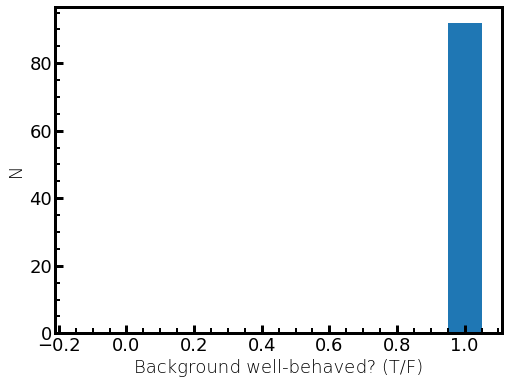

In [16]:
# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (8, 6)})
plt.rcParams.update({'font.size' : 18})

# Histogram the background flags; True=1, False=0 -- all should evaluate True.
plt.hist(bgflags, bins=np.arange(-0.15,1.15,0.1))
plt.xlabel('Background well-behaved? (T/F)')
plt.ylabel('N')
plt.minorticks_on()
plt.show()

### Using an assert statement, confirm that _all_ background images are well-behaved.

In [17]:
assert(np.all(bgflags))
print('All CCDs have an associated background.')

All CCDs have an associated background.


### Testing - load calexp and calexpBackground and display them:

Check a few random images to see whether the background frame exists, and what it looks like.

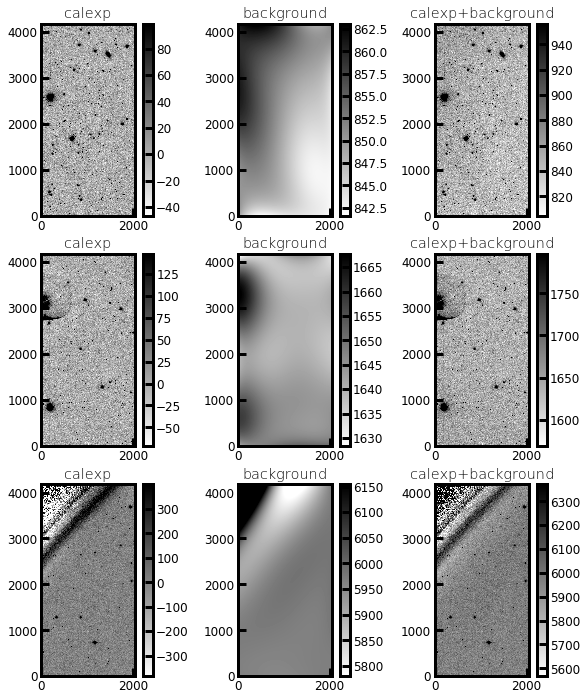

In [18]:
# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (10, 12)})
plt.rcParams.update({'font.size' : 12})

nrows = 3
f, ax = plt.subplots(nrows, 3)
axnum = 0
axs = ax.flatten()

for ii in range(nrows):
    cc = butler.get('calexp', dataId = datarefs[ii])
    bb = butler.get('calexpBackground', dataId = datarefs[ii])
    
    im = cc.image.array
    bg = bb.getImage().array
    implusbg = im + bg

    # Create an ImageNormalize object
    norm_im = ImageNormalize(im, interval=ZScaleInterval(),
                             stretch=LinearStretch())
    norm_bg = ImageNormalize(bg, interval=ZScaleInterval(),
                             stretch=LinearStretch())
    norm_implusbg = ImageNormalize(implusbg, interval=ZScaleInterval(),
                             stretch=LinearStretch())

    im0 = axs[axnum].imshow(im, norm=norm_im, origin='lower', cmap='binary')
    axs[axnum].set_title('calexp')
    plt.colorbar(im0, ax=axs[axnum])
    axnum += 1
    im1 = axs[axnum].imshow(bg, norm=norm_bg, origin='lower', cmap='binary')
    axs[axnum].set_title('background')
    plt.colorbar(im1, ax=axs[axnum])
    axnum += 1
    im2 = axs[axnum].imshow(implusbg, norm=norm_implusbg, origin='lower', cmap='binary')
    axs[axnum].set_title('calexp+background')
    plt.colorbar(im2, ax=axs[axnum])
    axnum += 1
